# Price Correction

In [ ]:
import pandas as pd

# Load the data
file_path = 'Superstore Dataset.xlsx'  # Update the path to your Excel file
df = pd.read_excel(file_path)

# Calculate price per unit
df['Unit Price'] = df['Sales'] / df['Quantity']

# Function to cluster prices within a 25% variance
def cluster_prices(group):
    group = group.sort_values(by='Unit Price')
    clustered = []
    while not group.empty:
        base_price = group.iloc[0]['Unit Price']
        cluster = group[(group['Unit Price'] >= base_price * 0.75) & (group['Unit Price'] <= base_price * 1.25)]
        clustered.append({
            'Segment': group.iloc[0]['Segment'],
            'Country': group.iloc[0]['Country'],
            'Product Name': group.iloc[0]['Product Name'],
            'Clustered Price': cluster['Unit Price'].mean(),
            'Count': len(cluster)  # Count of entries in the cluster
        })
        group = group.drop(cluster.index)
    return pd.DataFrame(clustered)

# Apply the clustering function to each group
clustered_prices = df.groupby(['Segment', 'Country', 'Product Name']).apply(cluster_prices).reset_index(drop=True)

# Compute weighted average based on counts
def weighted_average(group):
    return (group['Clustered Price'] * group['Count']).sum() / group['Count'].sum()

# Calculate weighted average for each Segment, Country, and Product Name
weighted_avg_by_group = clustered_prices.groupby(['Segment', 'Country', 'Product Name']).apply(weighted_average).reset_index(name='Weighted Average')

# Merge the original DataFrame with the weighted average DataFrame
merged_df = pd.merge(df, weighted_avg_by_group, on=['Segment', 'Country', 'Product Name'], how='left')

# Calculate the 25th and 75th percentiles of the 'Unit Price' column at the same level as 'Segment', 'Country', 'Product Name'
percentile_25 = merged_df.groupby(['Segment', 'Country', 'Product Name'])['Unit Price'].quantile(0.25)
percentile_75 = merged_df.groupby(['Segment', 'Country', 'Product Name'])['Unit Price'].quantile(0.75)

# Function to determine new unit price based on percentiles
def determine_new_unit_price(row):
    percentile_25_value = percentile_25.loc[(row['Segment'], row['Country'], row['Product Name'])]
    percentile_75_value = percentile_75.loc[(row['Segment'], row['Country'], row['Product Name'])]
    if row['Unit Price'] >= percentile_25_value and row['Unit Price'] <= percentile_75_value:
        return row['Unit Price']
    else:
        return row['Weighted Average']

# Apply the function to create the new_unit_price column
merged_df['new_unit_price'] = merged_df.apply(determine_new_unit_price, axis=1)

# Display the updated DataFrame
print(merged_df)


In [29]:
merged_df['Corrected Sales'] = merged_df['Quantity'] * merged_df['new_unit_price']

# Prediction Modelling

In [30]:
merged_df.drop(['Order ID','Row ID','Customer ID', 'Customer Name', 'Postal Code', 'Product ID', 'City'],axis=1, inplace=True)

In [31]:
merged_df.drop(['Product Name'],axis=1, inplace=True)

In [32]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Convert datetime columns into numeric features
merged_df['Order_Year'] = merged_df['Order Date'].dt.year
merged_df['Order_Month'] = merged_df['Order Date'].dt.month
merged_df['Order_Day'] = merged_df['Order Date'].dt.day

merged_df['Ship_Year'] = merged_df['Ship Date'].dt.year
merged_df['Ship_Month'] = merged_df['Ship Date'].dt.month
merged_df['Ship_Day'] = merged_df['Ship Date'].dt.day

# Drop the original datetime columns
merged_df.drop(['Order Date', 'Ship Date'], axis=1, inplace=True)

# Label encode categorical variables
cat_columns = ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']
label_encoders = {}
for col in cat_columns:
    label_encoders[col] = LabelEncoder()
    merged_df[col] = label_encoders[col].fit_transform(merged_df[col])

Cross-Validation Scores (Negative MSE): [-11387.94726019 -19408.11876331   -841.64929105   -692.95041842
 -24696.13920386]
Average Cross-Validation Score (Negative MSE): -11405.360987364535
Test Mean Squared Error: 74.21071449280736
Test R-squared: 0.9998112510701617


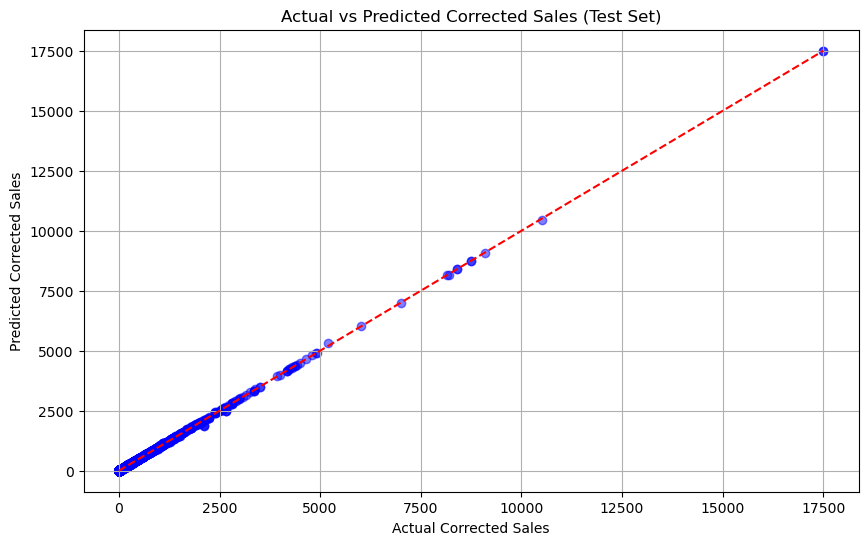

In [33]:
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Define the cross-validation strategy
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# Print the cross-validation scores
print("Cross-Validation Scores (Negative MSE):", cv_scores)

# Average cross-validation score
avg_cv_score = np.mean(cv_scores)
print("Average Cross-Validation Score (Negative MSE):", avg_cv_score)

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Evaluate model performance on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("Test Mean Squared Error:", mse_test)
print("Test R-squared:", r2_test)

# Plot detailed graph for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('Actual Corrected Sales')
plt.ylabel('Predicted Corrected Sales')
plt.title('Actual vs Predicted Corrected Sales (Test Set)')
plt.grid(True)
plt.show()

In [34]:
# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = calculate_mape(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 3.3359875105682315
